## Requirements and Imports


In [1]:
import copy
import os
from pathlib import Path
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_auc_score , pairwise_distances
import torch
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import scipy.sparse as sp
from numba import jit
import models
import metrics
device

device(type='cuda', index=0)

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20.5
BIGGER_SIZE = 24
#plt.rcParams["font.family"] = "Verdana"
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sc.set_figure_params(scanpy=True, fontsize=20.5)


In [3]:
import scvi
adata = scvi.data.pbmc_dataset()
adata.var['alt_names']=adata.var_names
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

Global seed set to 0


INFO     File data/gene_info_pbmc.csv already downloaded                                                           
INFO     File data/pbmc_metadata.pickle already downloaded                                                         
INFO     File data/pbmc8k/filtered_gene_bc_matrices.tar.gz already downloaded                                      
INFO     Extracting tar file                                                                                       


/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


INFO     Removing extracted data at data/pbmc8k/filtered_gene_bc_matrices                                          
INFO     File data/pbmc4k/filtered_gene_bc_matrices.tar.gz already downloaded                                      
INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at data/pbmc4k/filtered_gene_bc_matrices                                          


/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 11990 × 3346
    obs: 'n_counts', 'batch', 'labels', 'str_labels'
    var: 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts', 'alt_names'
    uns: 'cell_types', 'pca', 'neighbors', 'umap'
    obsm: 'design', 'raw_qc', 'normalized_qc', 'qc_pc', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [4]:
adata.obs['str_labels'].value_counts()

CD4 T cells          4996
CD14+ Monocytes      2227
B cells              1621
CD8 T cells          1448
Other                 463
NK cells              457
FCGR3A+ Monocytes     351
Dendritic Cells       339
Megakaryocytes         88
Name: str_labels, dtype: int64

In [5]:
adata.var['alt_names'].loc['ENSG00000168685'] = 'IL7R'
adata.var['alt_names'].loc['ENSG00000126353']='CCR7'
adata.var['alt_names'].loc['ENSG00000196154']='S100A4'
adata.var['alt_names'].loc['ENSG00000105369']='CD79A'
adata.var['alt_names'].loc['ENSG00000153563']='CD8A'
adata.var['alt_names'].loc['ENSG00000170458']='CD14'
adata.var['alt_names'].loc['ENSG00000131981']='LGALS3'
adata.var['alt_names'].loc['ENSG00000105374']='NKG7'
adata.var['alt_names'].loc['ENSG00000111796']='KLRB1'
adata.var['alt_names'].loc['ENSG00000179639']='FCER1A'
adata.var['alt_names'].loc['ENSG00000101439']='CST3'
adata.var['alt_names'].loc['ENSG00000163736']='PPBP'
adata.var['alt_names'].loc['ENSG00000116824'] = 'CD2'
adata.var['alt_names'].loc['ENSG00000188404']='SELL'
adata.var['alt_names'].loc['ENSG00000168329']='CX3CR1'
adata.var['alt_names'].loc['ENSG00000160255']='ITGB2'
adata.var['alt_names'].loc['ENSG00000125498']='KIR2DL1'
adata.var['alt_names'].loc['ENSG00000243772']='KIR2DL3'
adata.var['alt_names'].loc['ENSG00000139187']='KLRG1'
adata.var['alt_names'].loc['ENSG00000180644']='PRF1'
adata.var['alt_names'].loc['ENSG00000145649']='GZMA'
adata.var['alt_names'].loc['ENSG00000100453']='GZMB'
adata.var['alt_names'].loc['ENSG00000163221'] = 'S100A12'
adata.var['alt_names'].loc['ENSG00000132965']='ALOX5AP'
adata.var['alt_names'].loc['ENSG00000178623']='GPR35'
adata.var['alt_names'].loc['ENSG00000019169']='MARCO'
adata.var['alt_names'].loc['ENSG00000105371']='ICAM4'
adata.var['alt_names'].loc['ENSG00000007312']='CD79b'

marker_genes_dict= {
    'B cells':['CD79A'],
    'CD4 T cells':['IL7R','CCR7'],
    'CD8 T cells':['CD8A','NKG7','KLRB1'],
    'CD14+ Monocytes':['CD14','LGALS3'],
    'Dendritic cells':['FCER1A','CST3'],
    'NK Cells':['NKG7','KLRB1']}


/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [6]:
adata= adata[adata.obs['str_labels'].isin(['B cells', 'CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'Dendritic Cells' ,'FCGR3A+ Monocytes', 'NK cells'])]

In [7]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [8]:
adata_scaled = adata.copy()
sc.pp.scale(adata_scaled)

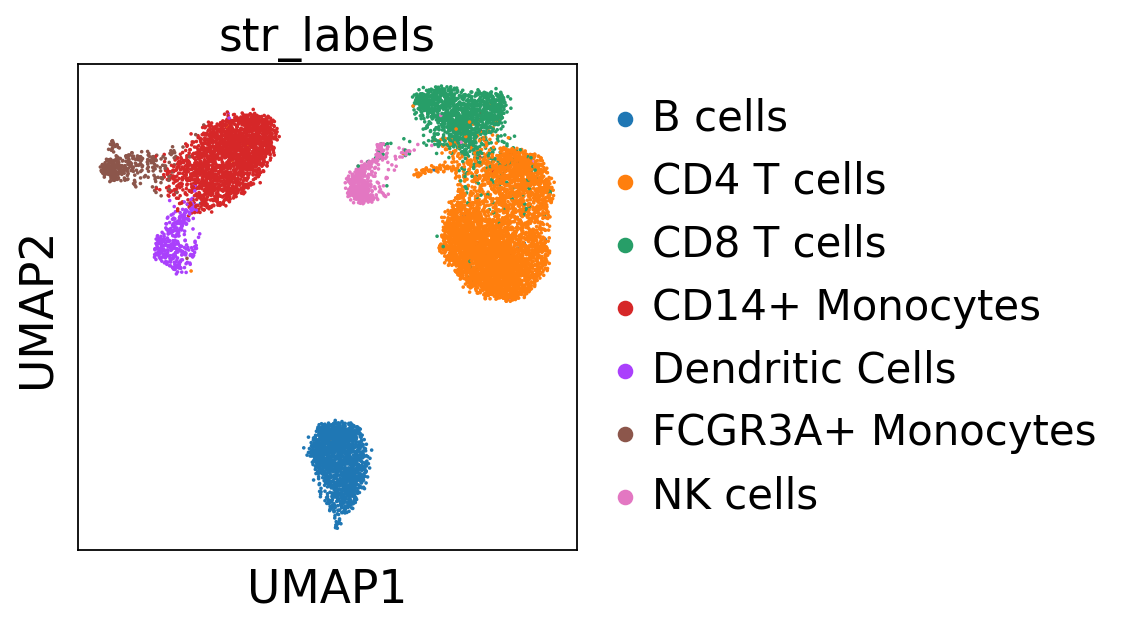

In [9]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='str_labels')

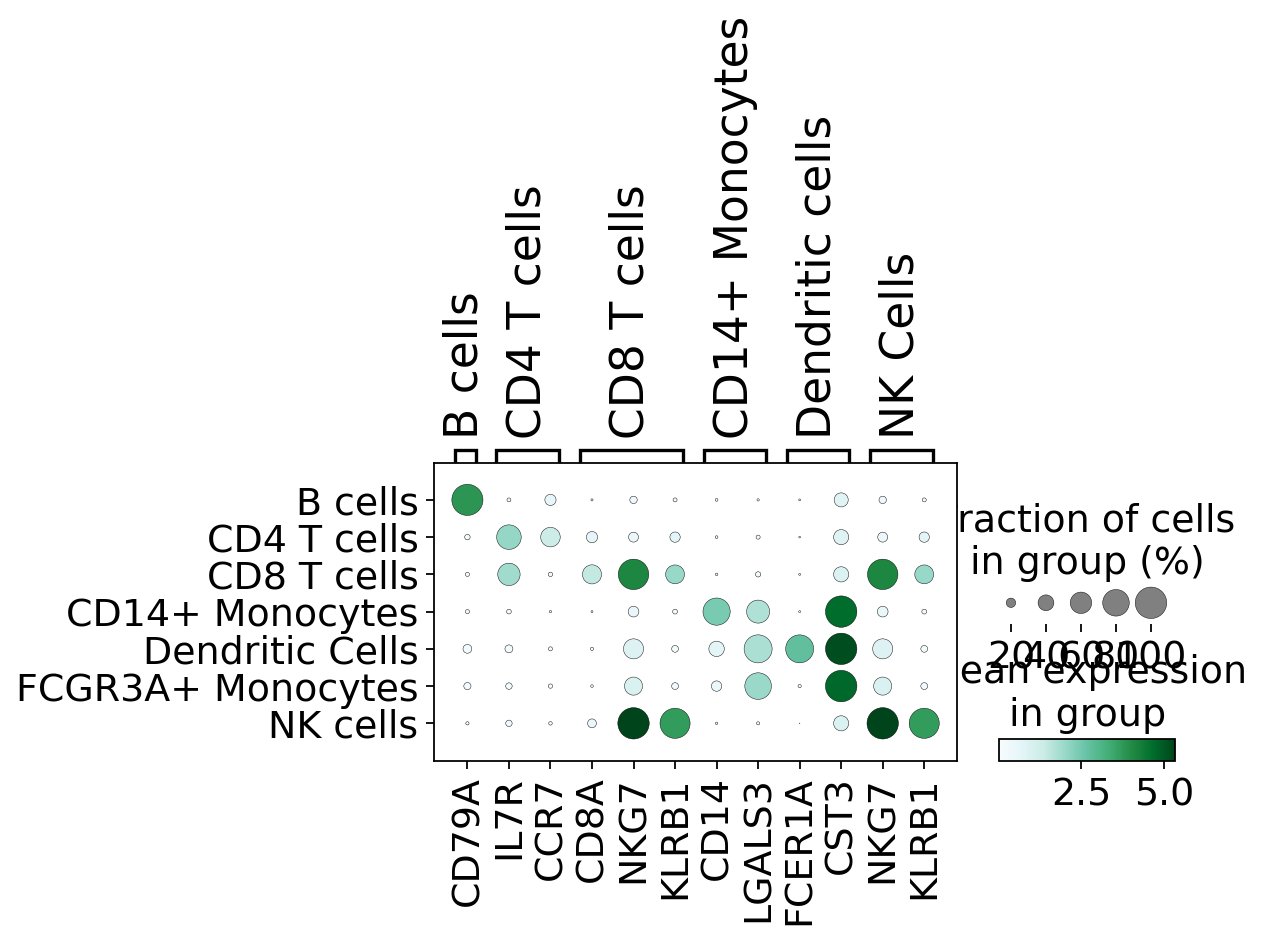

In [10]:
ax = sc.pl.dotplot(adata, marker_genes_dict, groupby='str_labels', gene_symbols='alt_names', cmap='BuGn')


In [11]:
epoch_num=100
prob_list = models.follow_training_dyn_neural_net(adata, label_key='str_labels',iterNum=epoch_num, device=device)

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.389
[1,    12] loss: 1.927
[1,    22] loss: 1.870
[1,    32] loss: 1.790
[1,    42] loss: 1.708
[2,     2] loss: 0.322
[2,    12] loss: 1.543
[2,    22] loss: 1.398
[2,    32] loss: 1.257
[2,    42] loss: 1.108
[3,     2] loss: 0.194
[3,    12] loss: 0.903
[3,    22] loss: 0.788
[3,    32] loss: 0.689
[3,    42] loss: 0.614
[4,     2] loss: 0.110
[4,    12] loss: 0.516
[4,    22] loss: 0.465
[4,    32] loss: 0.410
[4,    42] loss: 0.368
[5,     2] loss: 0.066
[5,    12] loss: 0.316
[5,    22] loss: 0.309
[5,    32] loss: 0.288
[5,    42] loss: 0.251
[6,     2] loss: 0.051
[6,    12] loss: 0.235
[6,    22] loss: 0.214
[6,    32] loss: 0.201
[6,    42] loss: 0.214
[7,     2] loss: 0.043
[7,    12] loss: 0.182
[7,    22] loss: 0.172
[7,    32] loss: 0.152
[7,    42] loss: 0.172
[8,     2] loss: 0.033
[8,    12] loss: 0.151
[8,    22] loss: 0.144
[8,    32] loss: 0.143
[8,    42] loss: 0.156
[9,     2] loss: 0.033
[9,    12] loss: 0.129
[9,    22] loss: 0.135
[9,    32] 

[70,     2] loss: 0.002
[70,    12] loss: 0.016
[70,    22] loss: 0.011
[70,    32] loss: 0.017
[70,    42] loss: 0.015
[71,     2] loss: 0.005
[71,    12] loss: 0.019
[71,    22] loss: 0.020
[71,    32] loss: 0.016
[71,    42] loss: 0.013
[72,     2] loss: 0.004
[72,    12] loss: 0.015
[72,    22] loss: 0.012
[72,    32] loss: 0.012
[72,    42] loss: 0.016
[73,     2] loss: 0.005
[73,    12] loss: 0.020
[73,    22] loss: 0.018
[73,    32] loss: 0.018
[73,    42] loss: 0.016
[74,     2] loss: 0.002
[74,    12] loss: 0.017
[74,    22] loss: 0.017
[74,    32] loss: 0.019
[74,    42] loss: 0.017
[75,     2] loss: 0.004
[75,    12] loss: 0.012
[75,    22] loss: 0.016
[75,    32] loss: 0.018
[75,    42] loss: 0.016
[76,     2] loss: 0.002
[76,    12] loss: 0.017
[76,    22] loss: 0.021
[76,    32] loss: 0.020
[76,    42] loss: 0.017
[77,     2] loss: 0.002
[77,    12] loss: 0.017
[77,    22] loss: 0.012
[77,    32] loss: 0.015
[77,    42] loss: 0.014
[78,     2] loss: 0.004
[78,    12] loss

In [12]:
all_conf , all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata.n_obs, epoch_num=epoch_num)

In [13]:
cutoff_conf , cutoff_var = models.find_cutoff_paramter(adata,'str_labels',device,probability=0.1,percentile=25,epoch_num=epoch_num)

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.391
[1,    12] loss: 1.938
[1,    22] loss: 1.896
[1,    32] loss: 1.845
[1,    42] loss: 1.790
[2,     2] loss: 0.344
[2,    12] loss: 1.700
[2,    22] loss: 1.629
[2,    32] loss: 1.551
[2,    42] loss: 1.481
[3,     2] loss: 0.284
[3,    12] loss: 1.367
[3,    22] loss: 1.310
[3,    32] loss: 1.240
[3,    42] loss: 1.216
[4,     2] loss: 0.230
[4,    12] loss: 1.160
[4,    22] loss: 1.099
[4,    32] loss: 1.082
[4,    42] loss: 1.061
[5,     2] loss: 0.194
[5,    12] loss: 1.036
[5,    22] loss: 0.973
[5,    32] loss: 0.918
[5,    42] loss: 0.933
[6,     2] loss: 0.184
[6,    12] loss: 0.932
[6,    22] loss: 0.886
[6,    32] loss: 0.906
[6,    42] loss: 0.918
[7,     2] loss: 0.191
[7,    12] loss: 0.881
[7,    22] loss: 0.863
[7,    32] loss: 0.857
[7,    42] loss: 0.872
[8,     2] loss: 0.155
[8,    12] loss: 0.811
[8,    22] loss: 0.781
[8,    32] loss: 0.812
[8,    42] loss: 0.840
[9,     2] loss: 0.164
[9,    12] loss: 0.775
[9,    22] loss: 0.800
[9,    32] 

[70,    12] loss: 0.111
[70,    22] loss: 0.079
[70,    32] loss: 0.097
[70,    42] loss: 0.102
[71,     2] loss: 0.016
[71,    12] loss: 0.094
[71,    22] loss: 0.102
[71,    32] loss: 0.093
[71,    42] loss: 0.081
[72,     2] loss: 0.015
[72,    12] loss: 0.086
[72,    22] loss: 0.085
[72,    32] loss: 0.091
[72,    42] loss: 0.086
[73,     2] loss: 0.015
[73,    12] loss: 0.090
[73,    22] loss: 0.086
[73,    32] loss: 0.093
[73,    42] loss: 0.082
[74,     2] loss: 0.020
[74,    12] loss: 0.071
[74,    22] loss: 0.080
[74,    32] loss: 0.082
[74,    42] loss: 0.090
[75,     2] loss: 0.016
[75,    12] loss: 0.082
[75,    22] loss: 0.080
[75,    32] loss: 0.087
[75,    42] loss: 0.080
[76,     2] loss: 0.019
[76,    12] loss: 0.085
[76,    22] loss: 0.077
[76,    32] loss: 0.077
[76,    42] loss: 0.076
[77,     2] loss: 0.012
[77,    12] loss: 0.078
[77,    22] loss: 0.071
[77,    32] loss: 0.078
[77,    42] loss: 0.064
[78,     2] loss: 0.015
[78,    12] loss: 0.084
[78,    22] loss

In [14]:
adata.obs["var"] = all_var.detach().numpy()
adata.obs["conf"] = all_conf.detach().numpy()

In [15]:
adata.obs['conf_binaries'] = pd.Categorical((adata.obs['conf'] > cutoff_conf) | (adata.obs['var'] > cutoff_var))

In [16]:
adata.obs['CellType']=adata.obs['str_labels']

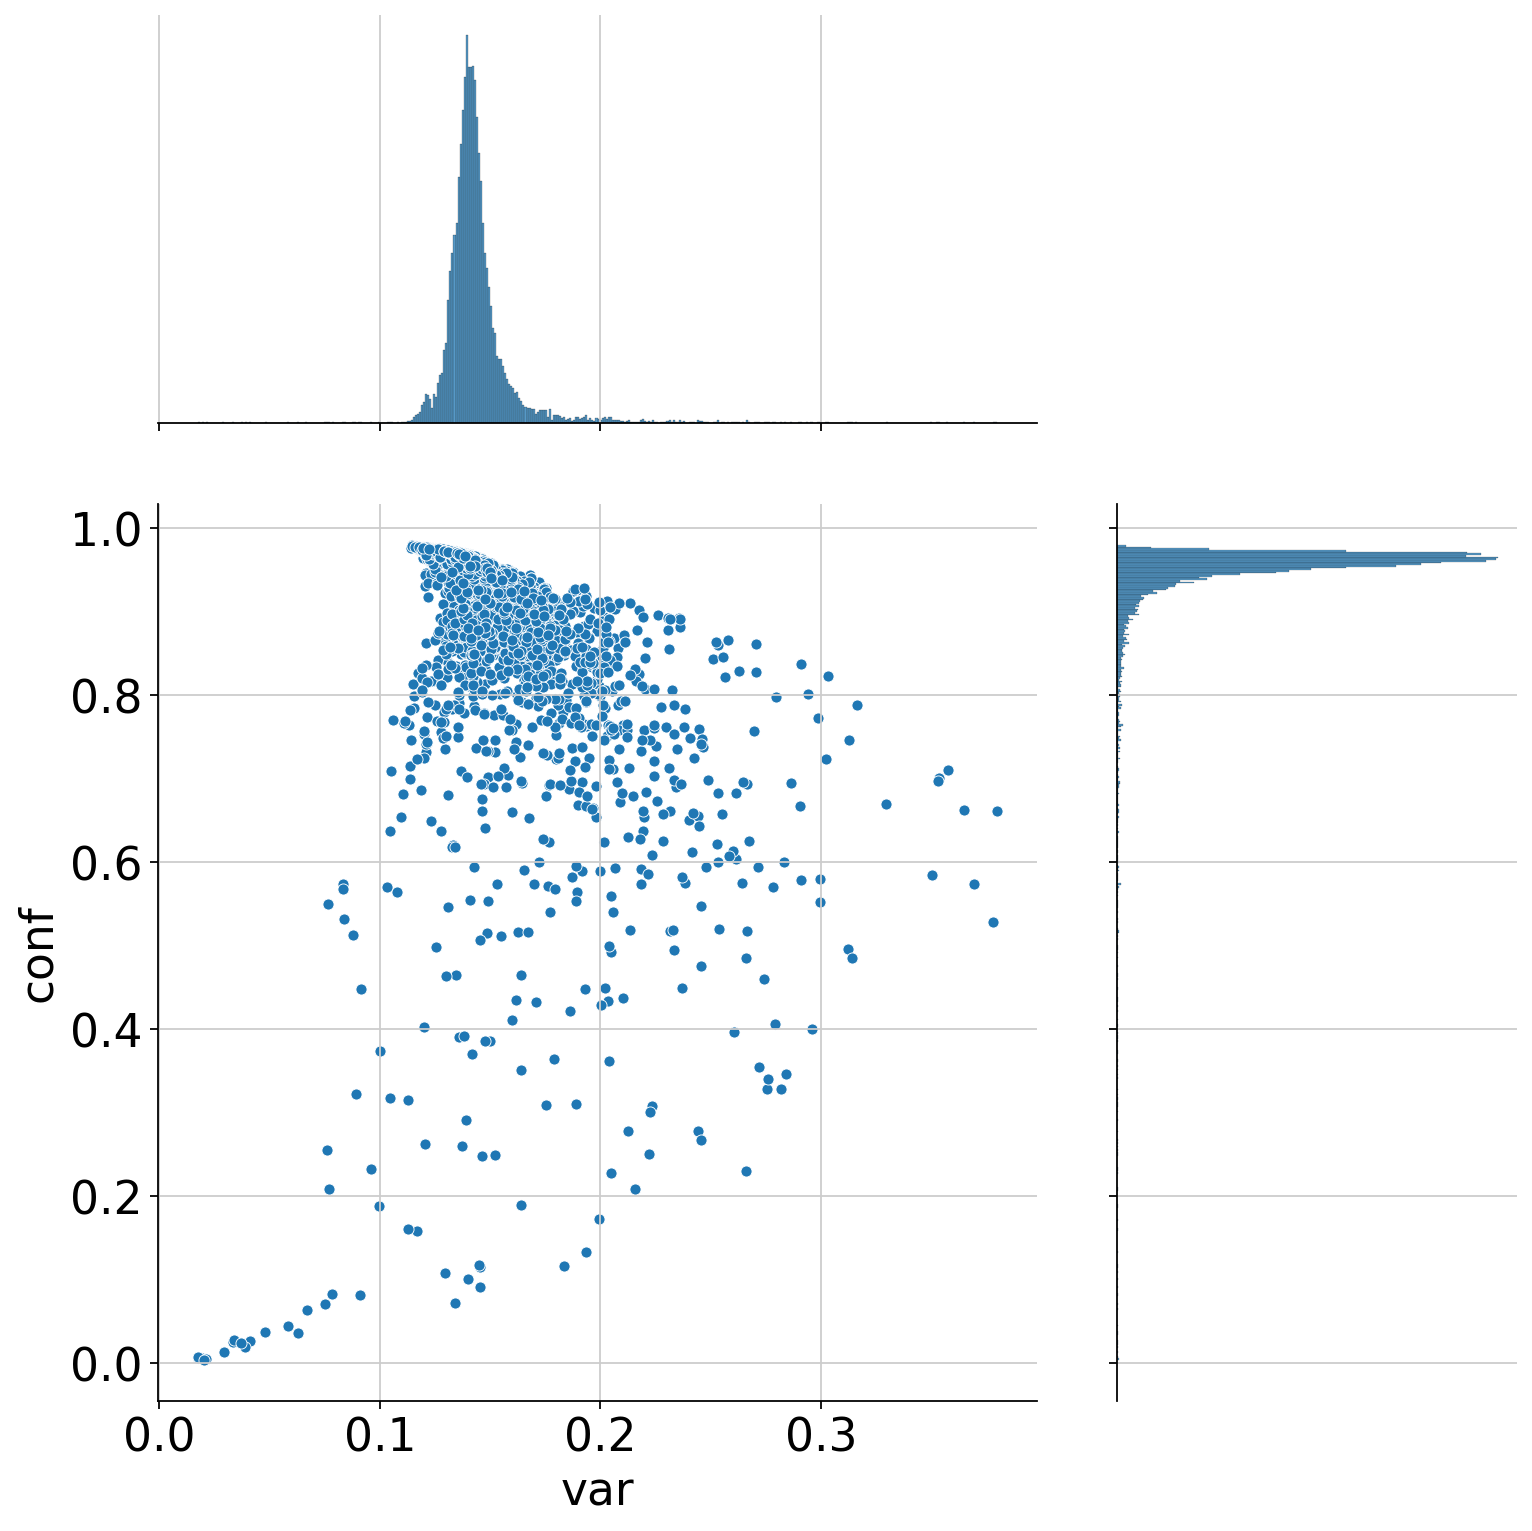

In [17]:

adata.obs['CellType']=adata.obs['str_labels']
sns.jointplot(data=adata.obs, x="var", y="conf",height=10,  s=25, ratio=2)
plt.ylabel('Confidence')
plt.xlabel('Variability')
plt.show()

In [18]:
cutoff_conf , cutoff_var

(0.2885604351758957, 0.2490183189511299)

In [19]:
adata.obs['conf_binaries'].value_counts()

True     11395
False       44
Name: conf_binaries, dtype: int64

In [20]:
sc.pp.pca(adata)#, color=['str_labels'])
sc.pp.neighbors(adata)#, color=['conf_binaries'])
sc.tl.umap(adata)#, color=['conf'])

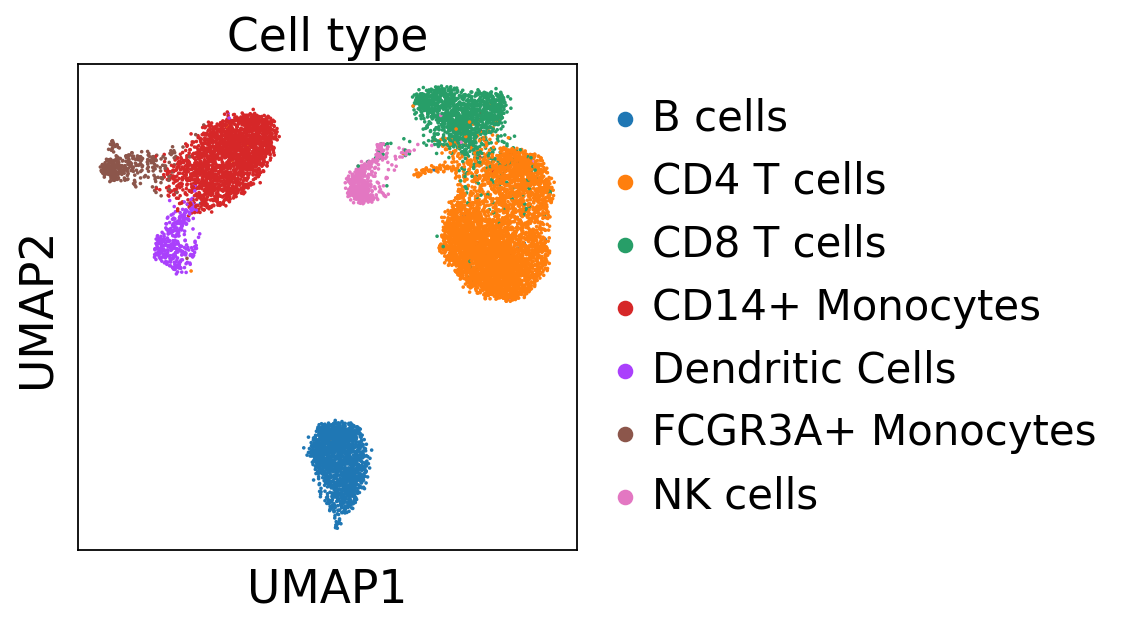

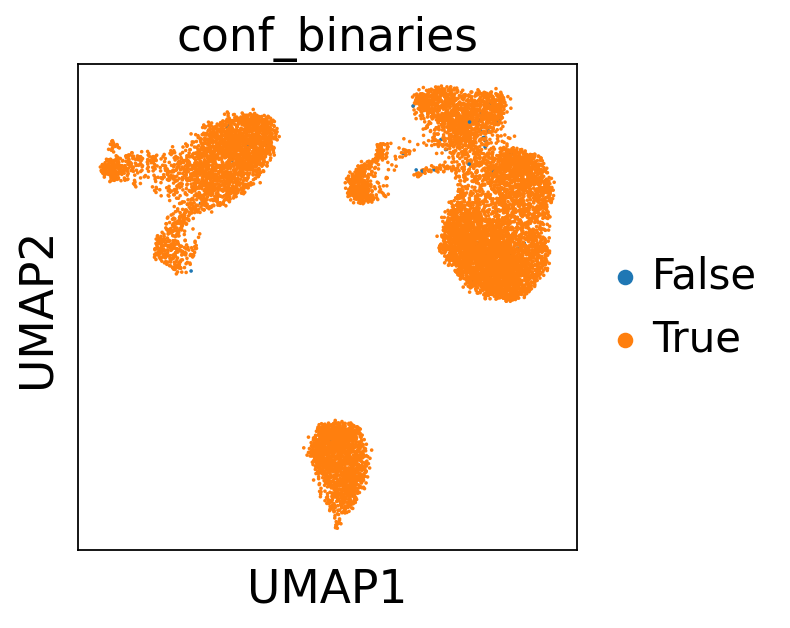

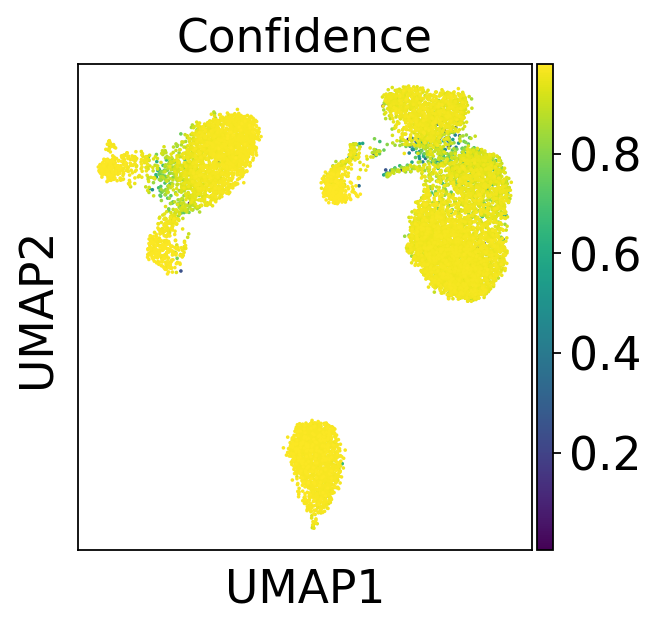

In [21]:
sc.pl.umap(adata, color=['str_labels'], title='Cell type')
sc.pl.umap(adata, color=['conf_binaries'])
sc.pl.umap(adata, color=['conf'], title='Confidence')

In [22]:
annotation_list =[]
for i in range(adata.n_obs):
    if (adata.obs['conf'][i] > cutoff_conf) | (adata.obs['var'][i] > cutoff_var):
        if (adata.obs['conf'][i] > 0.95) & (adata.obs['var'][i] < 0.15):
            annotation_list.append('Correctly annotated')
        else:
            annotation_list.append('Ambiguously annotated.')
    else:
            annotation_list.append('Erroneously annotated')

adata.obs['Annotation']=annotation_list
adata.obs[' ']=annotation_list


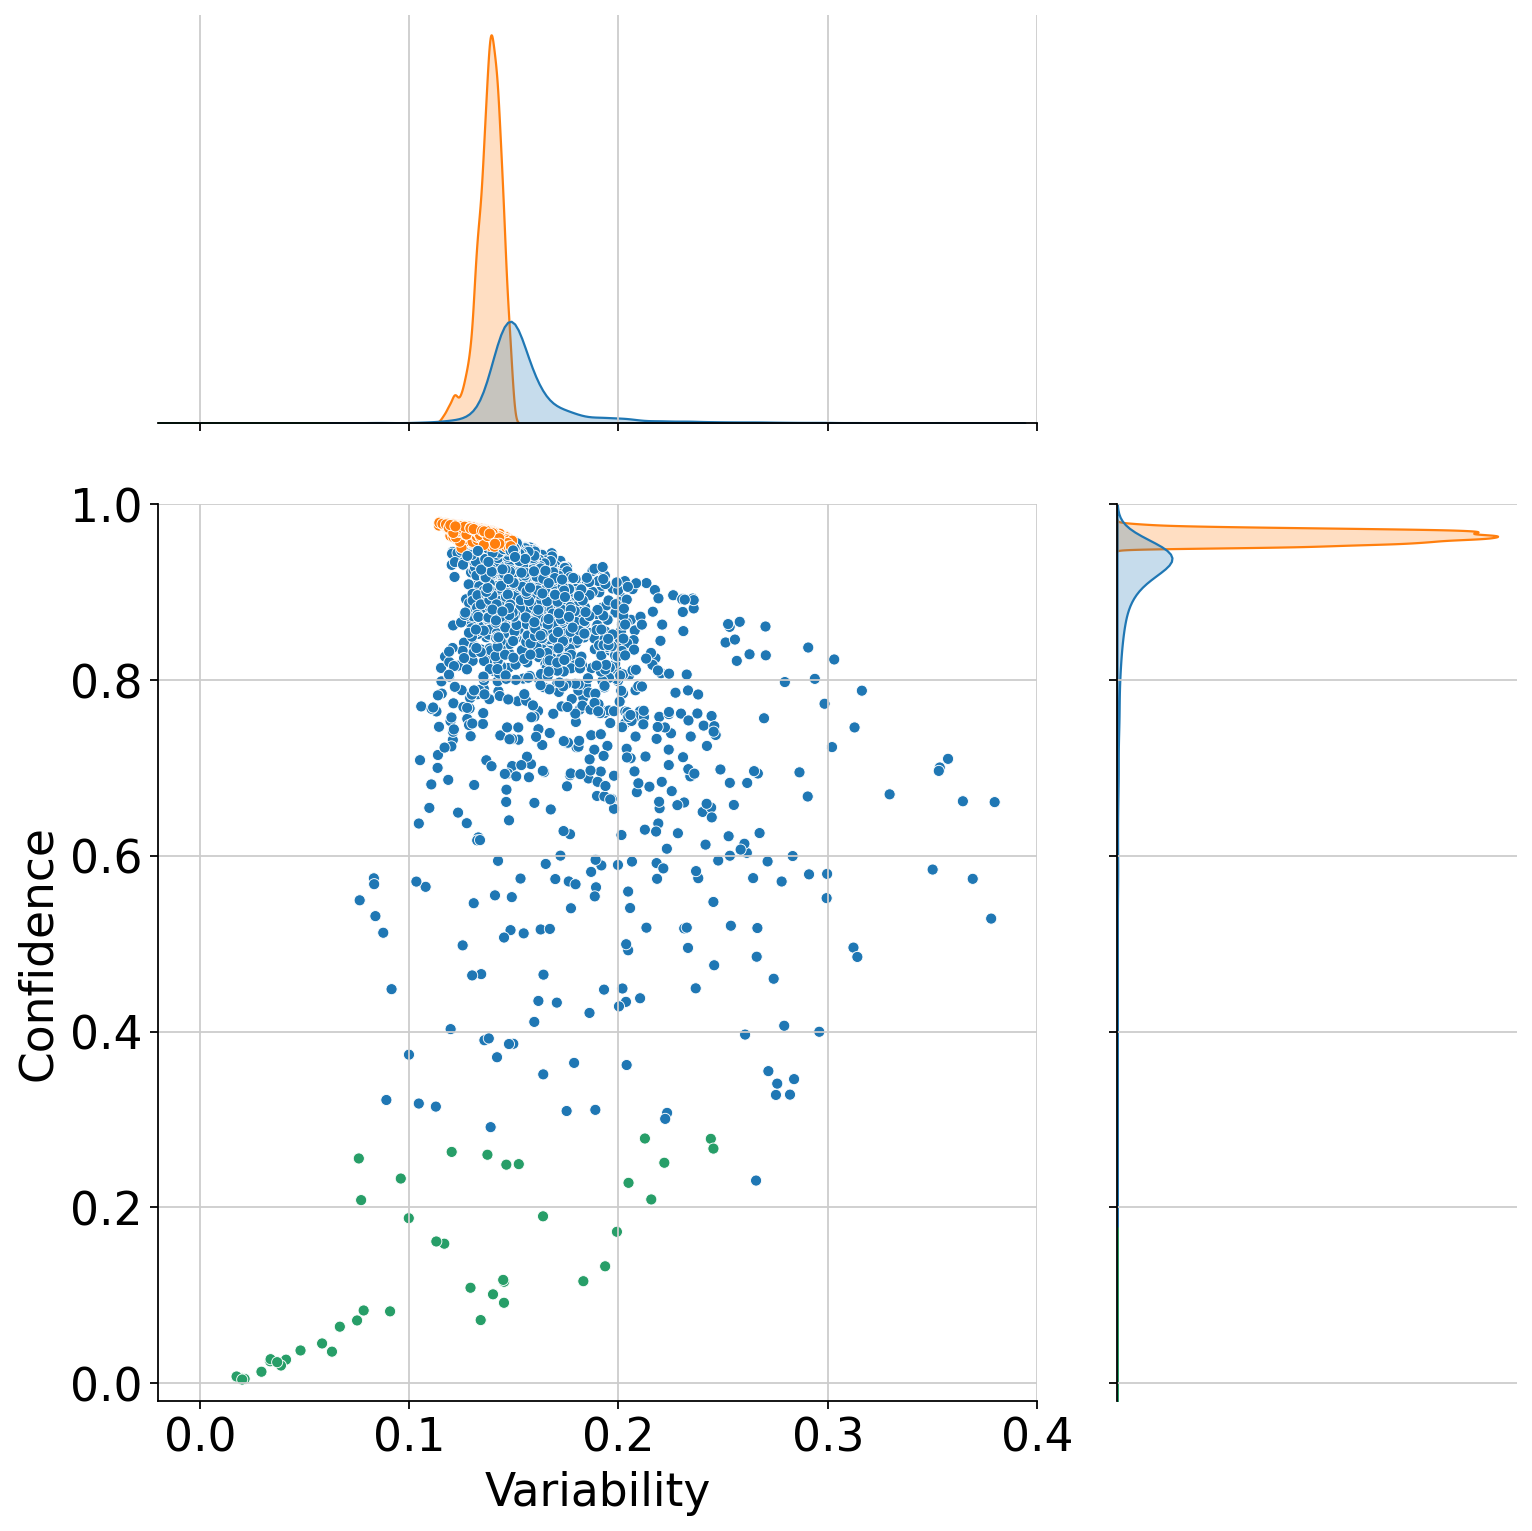

In [58]:
adata.obs['conf_non_ambiguous'] = pd.Categorical((adata.obs['conf'] > 0.95) | (adata.obs['var'] < 0.15))
adata.obs['Confidence']= adata.obs['conf']
adata.obs['Variability']= adata.obs['var']

fig = sns.jointplot(data=adata.obs, x="Variability", y="Confidence",hue=' ',height=10,  s=25, ratio=2,
                    xlim=[-0.02,0.4], ylim=[-0.02,1])
#plt.legend(bbox_to_anchor=(2.02, 2), loc='upper left', borderaxespad=0)
#sns.set_style(style='white')
fig.ax_joint.legend_.remove()

plt.show(fig)

In [24]:
gene_mapping = {
    'ENSG00000168685': 'IL7R',
    'ENSG00000126353': 'CCR7',
    'ENSG00000196154': 'S100A4',
    'ENSG00000105369': 'CD79A',
    'ENSG00000153563': 'CD8A',
    'ENSG00000170458': 'CD14',
    'ENSG00000131981': 'LGALS3',
    'ENSG00000105374': 'NKG7',
    'ENSG00000111796': 'KLRB1',
    'ENSG00000179639': 'FCER1A',
    'ENSG00000101439': 'CST3',
    'ENSG00000163736': 'PPBP',
    'ENSG00000116824': 'CD2',
    'ENSG00000188404': 'SELL',
    'ENSG00000111537': 'IFNG',
    'ENSG00000168329': 'CX3CR1',
    'ENSG00000160255': 'ITGB2',
    'ENSG00000125498': 'KIR2DL1',
    'ENSG00000243772': 'KIR2DL3',
    'ENSG00000139187': 'KLRG1',
    'ENSG00000180644': 'PRF1',
    'ENSG00000145649': 'GZMA',
    'ENSG00000100453': 'GZMB',
    'ENSG00000163221': 'S100A12',
    'ENSG00000132965': 'ALOX5AP',
    'ENSG00000178623': 'GPR35',
    'ENSG00000019169': 'MARCO',
    'ENSG00000105371': 'ICAM4',
    'ENSG00000007312': 'CD79b',
}



/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


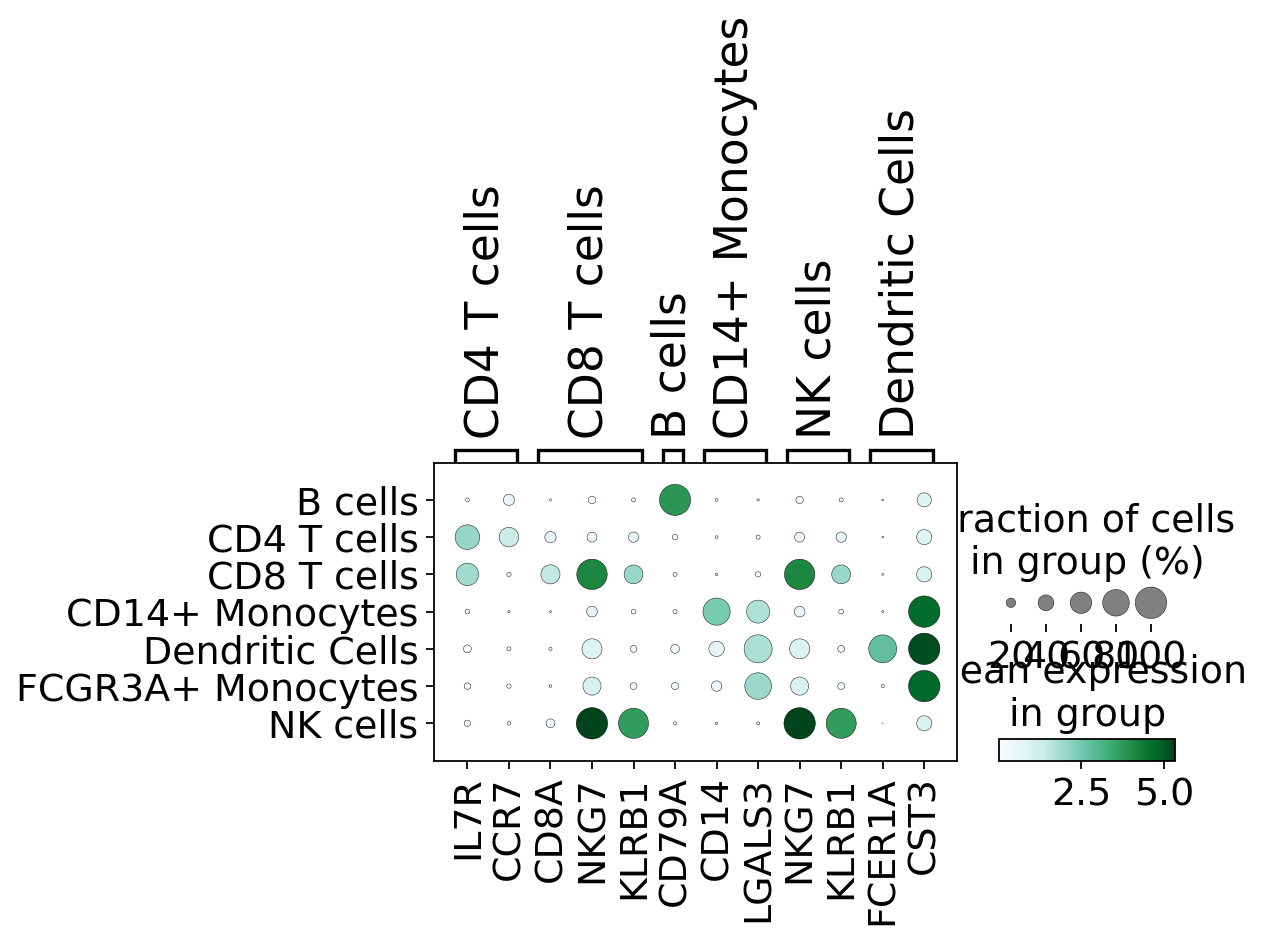

In [25]:
adata.var['alt_names'].loc['ENSG00000168685'] = 'IL7R'
adata.var['alt_names'].loc['ENSG00000126353']='CCR7'
adata.var['alt_names'].loc['ENSG00000196154']='S100A4'
adata.var['alt_names'].loc['ENSG00000105369']='CD79A'
adata.var['alt_names'].loc['ENSG00000153563']='CD8A'
adata.var['alt_names'].loc['ENSG00000170458']='CD14'
adata.var['alt_names'].loc['ENSG00000131981']='LGALS3'
adata.var['alt_names'].loc['ENSG00000105374']='NKG7'
adata.var['alt_names'].loc['ENSG00000111796']='KLRB1'
adata.var['alt_names'].loc['ENSG00000179639']='FCER1A'
adata.var['alt_names'].loc['ENSG00000101439']='CST3'
adata.var['alt_names'].loc['ENSG00000163736']='PPBP'
adata.var['alt_names'].loc['ENSG00000116824'] = 'CD2'
adata.var['alt_names'].loc['ENSG00000188404']='SELL'
adata.var['alt_names'].loc['ENSG00000168329']='CX3CR1'
adata.var['alt_names'].loc['ENSG00000160255']='ITGB2'
adata.var['alt_names'].loc['ENSG00000125498']='KIR2DL1'
adata.var['alt_names'].loc['ENSG00000243772']='KIR2DL3'
adata.var['alt_names'].loc['ENSG00000139187']='KLRG1'
adata.var['alt_names'].loc['ENSG00000180644']='PRF1'
adata.var['alt_names'].loc['ENSG00000145649']='GZMA'
adata.var['alt_names'].loc['ENSG00000100453']='GZMB'
adata.var['alt_names'].loc['ENSG00000163221'] = 'S100A12'
adata.var['alt_names'].loc['ENSG00000132965']='ALOX5AP'
adata.var['alt_names'].loc['ENSG00000178623']='GPR35'
adata.var['alt_names'].loc['ENSG00000019169']='MARCO'
adata.var['alt_names'].loc['ENSG00000105371']='ICAM4'
adata.var['alt_names'].loc['ENSG00000007312']='CD79b'

marker_genes_dict= {
    'CD4 T cells':['IL7R','CCR7'],
    'CD8 T cells':['CD8A','NKG7','KLRB1'],
    'B cells':['CD79A'],
    'CD14+ Monocytes':['CD14','LGALS3'],
    'NK cells':['NKG7','KLRB1'],
    'Dendritic Cells':['FCER1A','CST3']}
    

ax = sc.pl.dotplot(adata, marker_genes_dict, groupby='str_labels', gene_symbols='alt_names', cmap='BuGn')


In [26]:
corr_classified_list =[]
for i in range(adata.n_obs):
    if adata.obs['conf_binaries'][i]==True:
        corr_classified_list.append('Correct')
    else: 
        corr_classified_list.append('Erroneous')
adata.obs['annotation']=corr_classified_list

NK cells


/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


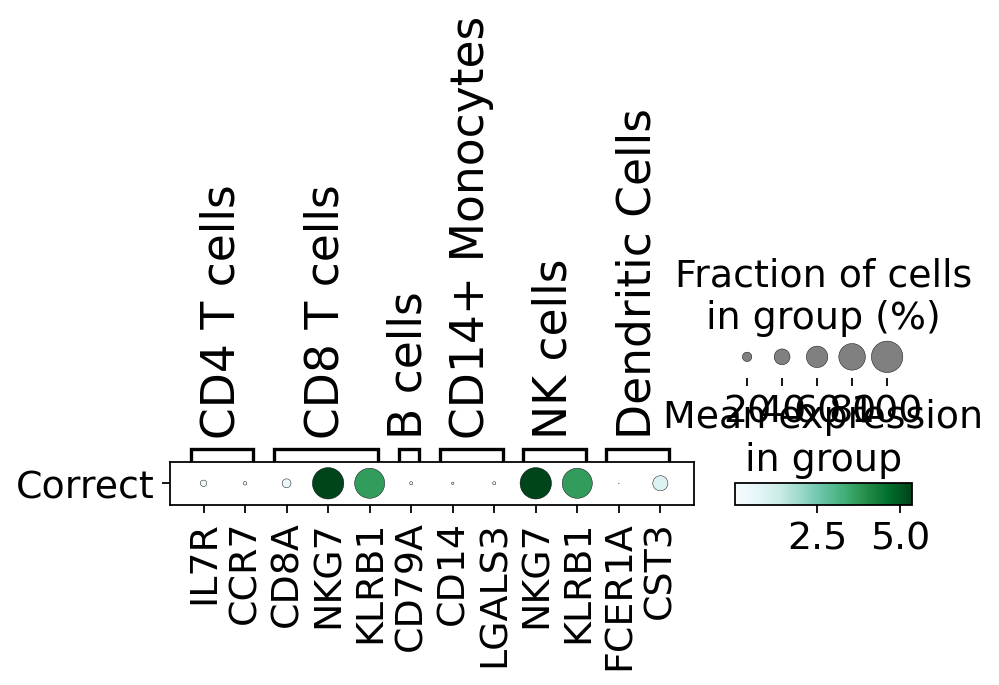

Dendritic Cells


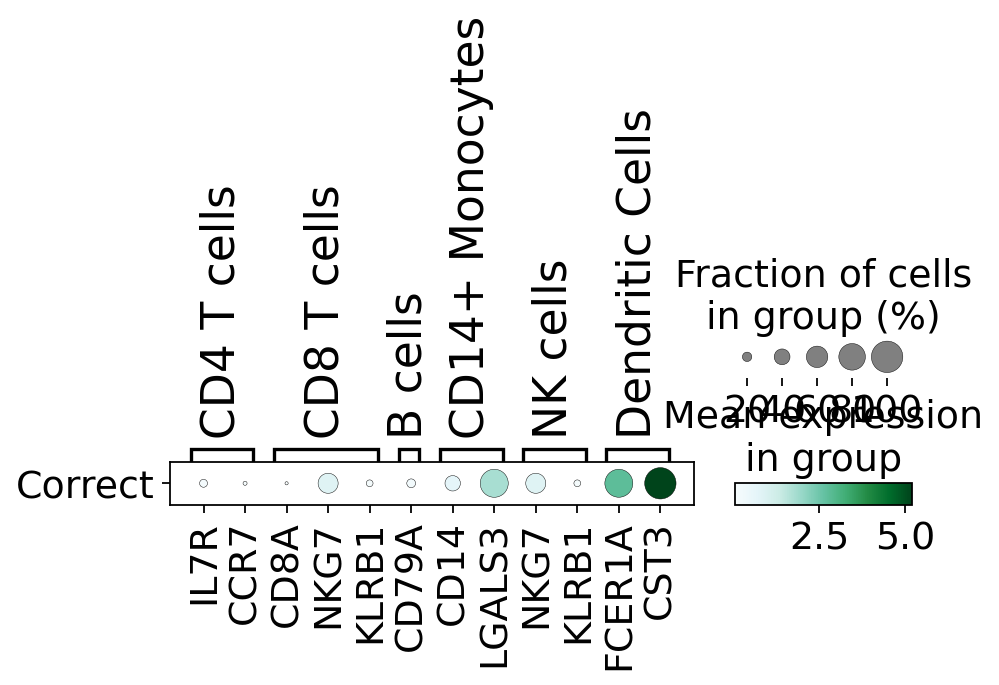

B cells


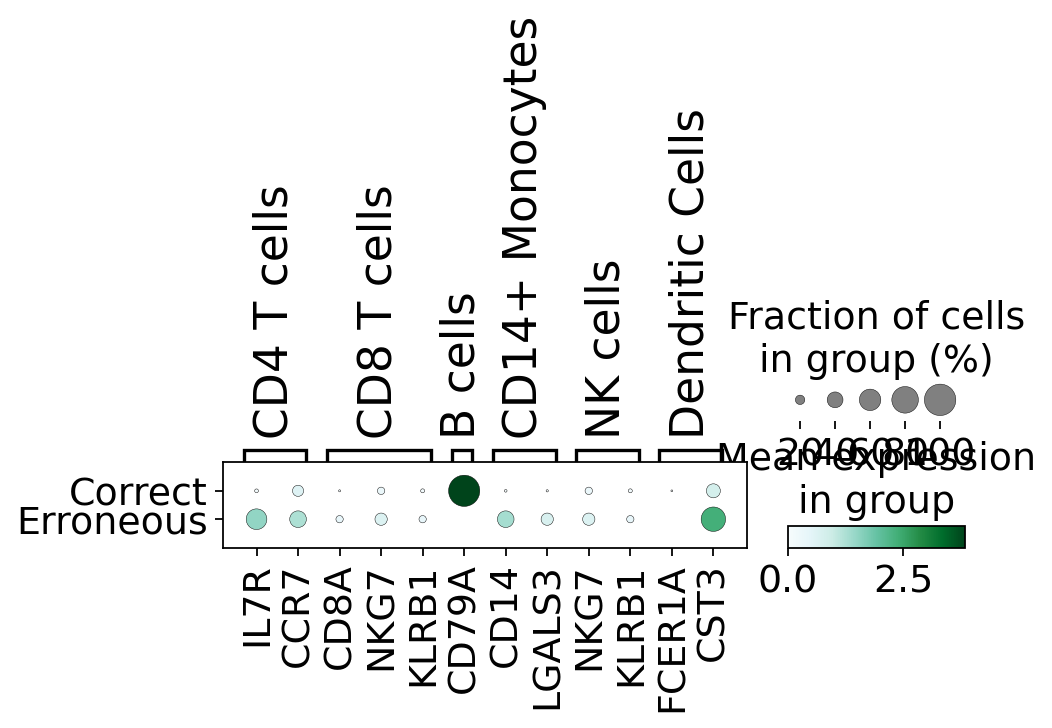

FCGR3A+ Monocytes


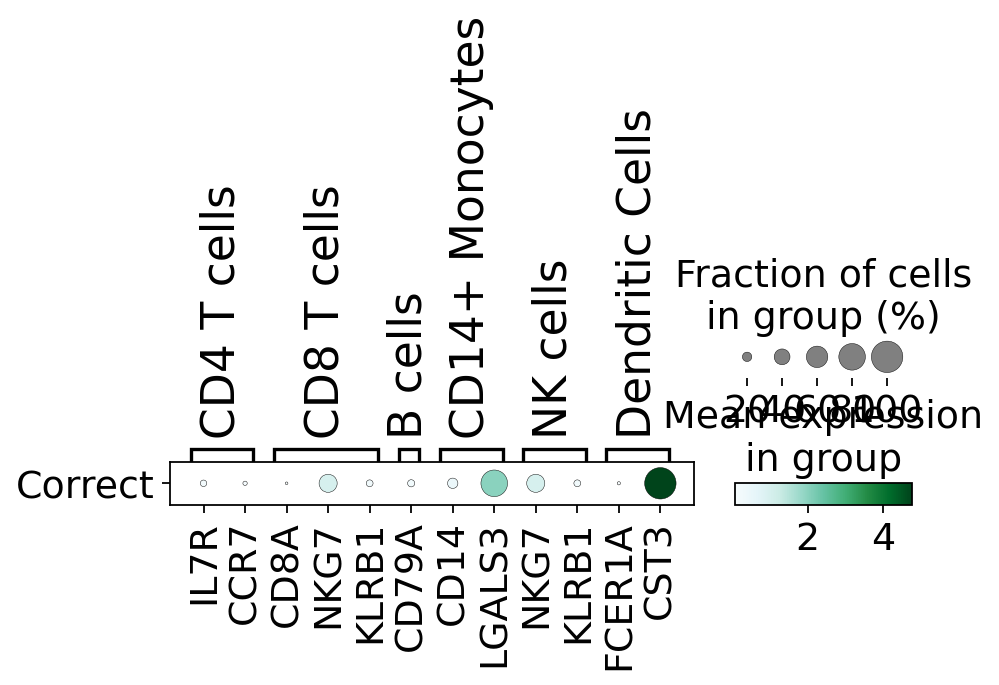

CD14+ Monocytes


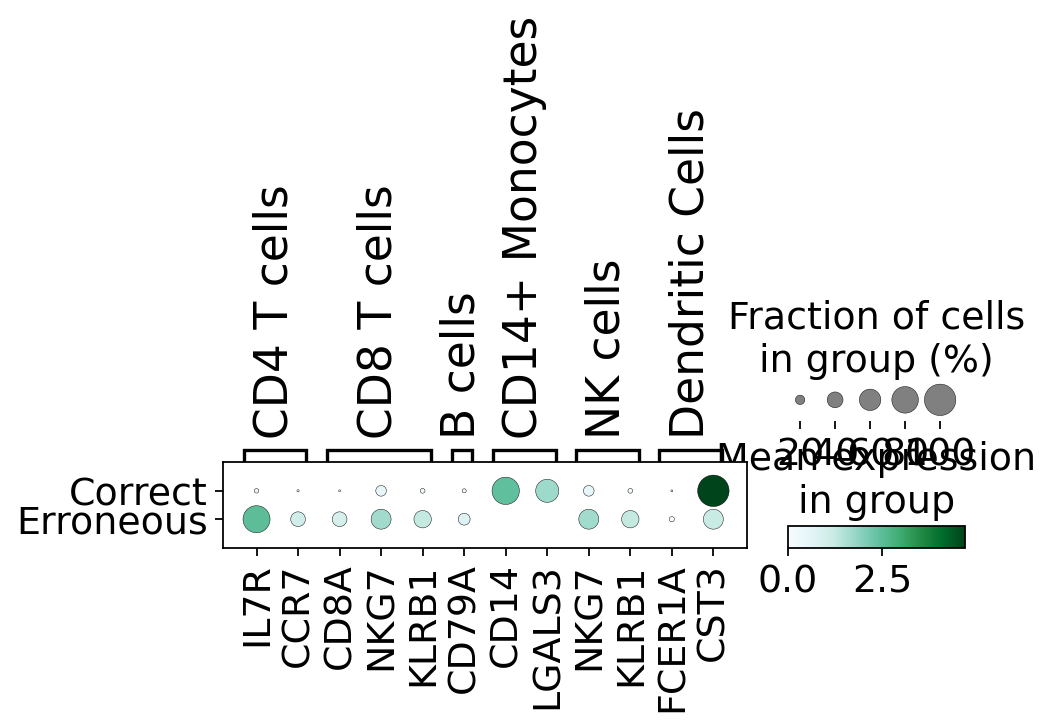

CD4 T cells


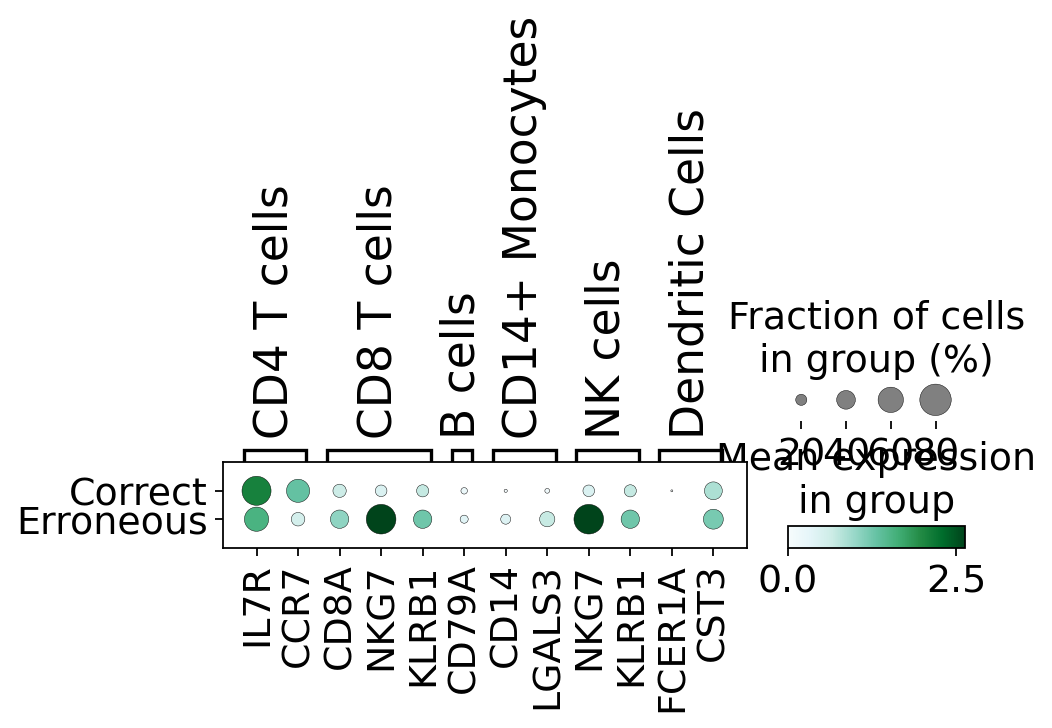

CD8 T cells


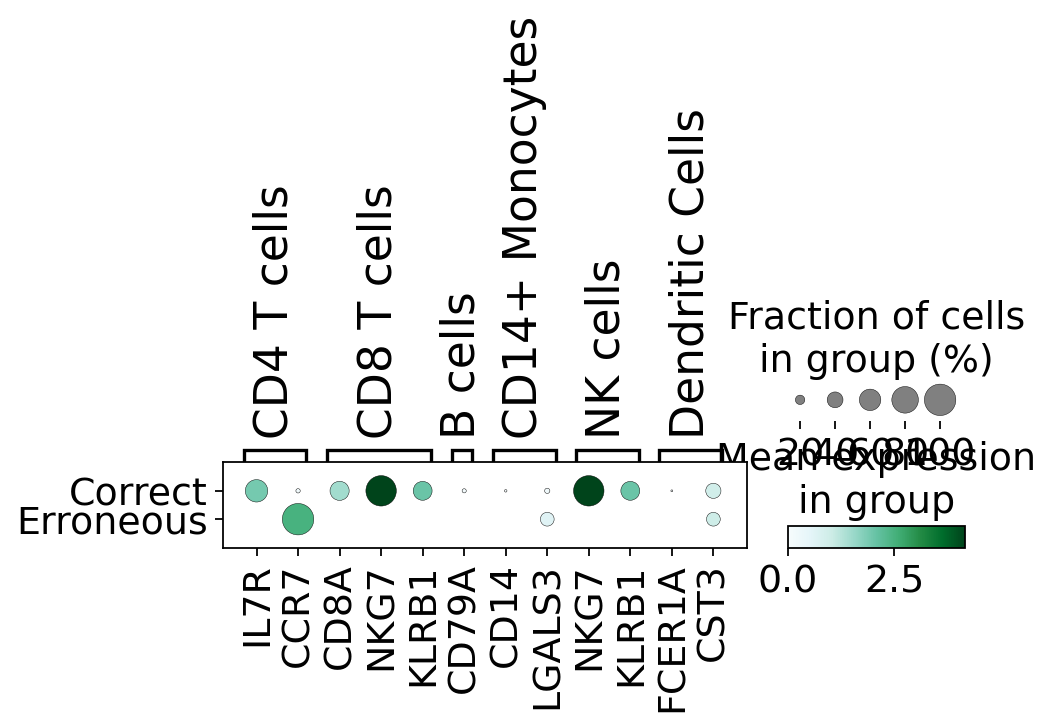

In [27]:

for celltype in set(adata.obs['str_labels']):
    adata_tmp= adata[adata.obs['str_labels'].isin([celltype])]
    print(celltype)
    
    ax = sc.pl.dotplot(adata_tmp, marker_genes_dict, groupby='annotation',cmap='BuGn', gene_symbols='alt_names')


In [28]:
adata_scaled.obs['conf']= adata.obs['conf']
adata_scaled.obs['var']= adata.obs['var']
adata_scaled.obs['conf_binaries']= adata.obs['conf_binaries']

In [29]:
cd56_genes_dict= {
    'CD56 bright':['IL7R','CCR7','CD2','SELL'], 
    'CD56 dim':['CX3CR1','ITGB2','KIR2DL1','KIR2DL3','KLRG1','PRF1','GZMA','GZMB'],     

                   }


/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  """


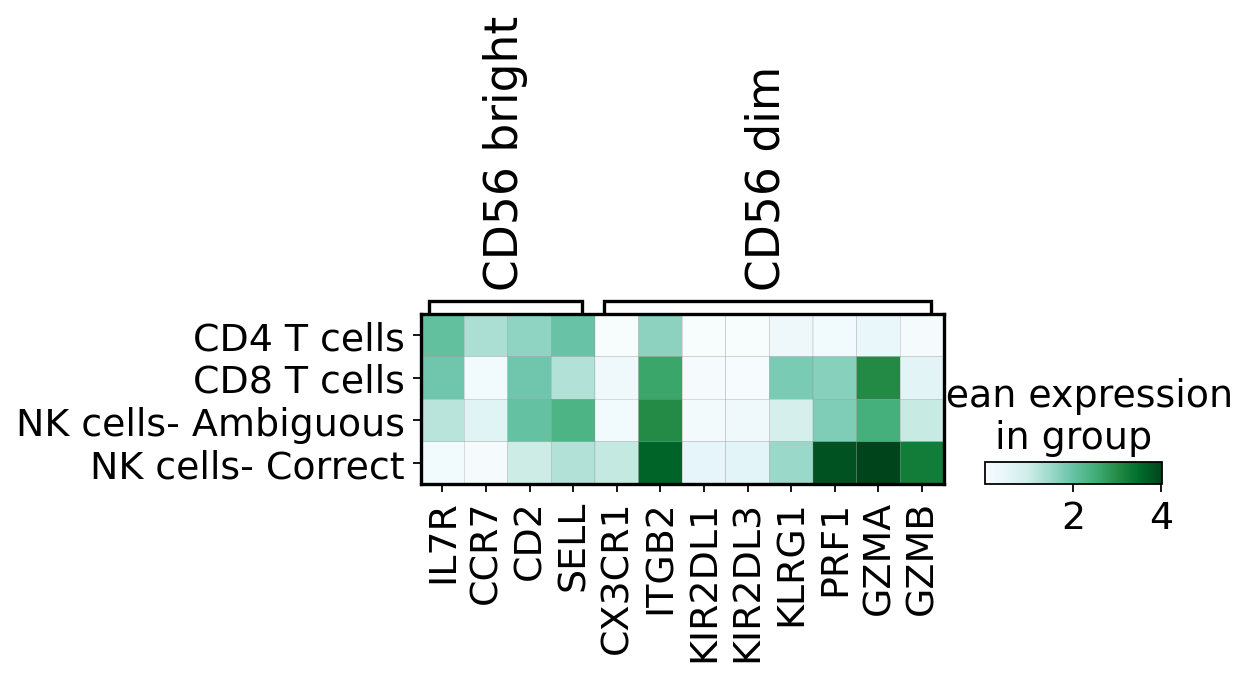

In [30]:
adata_nk_cd8= adata[adata.obs['conf_binaries'].isin([True])]
adata_nk_cd8= adata_nk_cd8[adata_nk_cd8.obs['str_labels'].isin(['NK cells','CD8 T cells','CD4 T cells'])]


adata_nk_cd8.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk_cd8.obs['conf'] > 0.95) | (adata_nk_cd8.obs['var'] < 0.15))

corr_classified_list =[]
for i in range(adata_nk_cd8.n_obs):
    if adata_nk_cd8.obs['str_labels'][i]=='CD8 T cells':
        corr_classified_list.append('CD8 T cells')
    elif adata_nk_cd8.obs['str_labels'][i]=='CD4 T cells':
        corr_classified_list.append('CD4 T cells')
    else:
        if adata_nk_cd8.obs['conf_non_ambiguous'][i]==True:
            corr_classified_list.append('NK cells- Correct')
        else: 
            corr_classified_list.append('NK cells- Ambiguous')
adata_nk_cd8.obs['amb_annotation']=corr_classified_list

ax = sc.pl.matrixplot(adata_nk_cd8, cd56_genes_dict, groupby='amb_annotation',cmap='BuGn', gene_symbols='alt_names')



/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  """


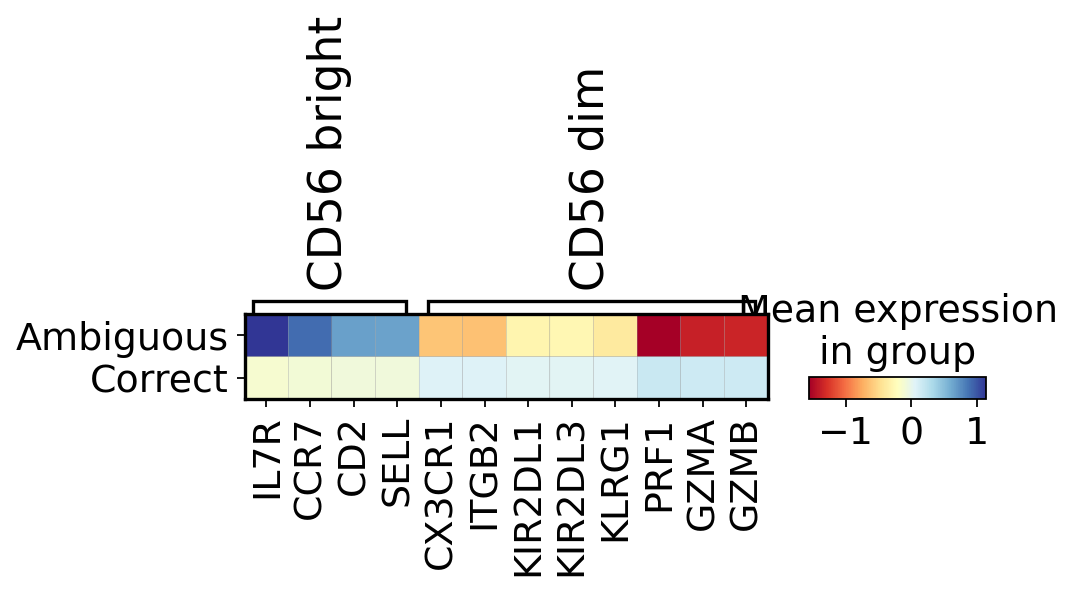

In [31]:
adata_nk= adata[adata.obs['conf_binaries'].isin([True])]
adata_nk= adata_nk[adata_nk.obs['str_labels'].isin(['NK cells'])]


adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.95) | (adata_nk.obs['var'] < 0.15))

corr_classified_list =[]
for i in range(adata_nk.n_obs):
    if adata_nk.obs['conf_non_ambiguous'][i]==True:
        corr_classified_list.append('Correct')
    else: 
        corr_classified_list.append('Ambiguous')
adata_nk.obs['amb_annotation']=corr_classified_list


adata_nk_sacled = adata_nk.copy()
sc.pp.scale(adata_nk_sacled)
#adata_nk.obs['conf_ambiguous'] = pd.Categorical(adata_nk.obs['conf'] > 0.95)
ax = sc.pl.matrixplot(adata_nk_sacled, cd56_genes_dict, groupby='amb_annotation',cmap='RdYlBu', gene_symbols='alt_names')



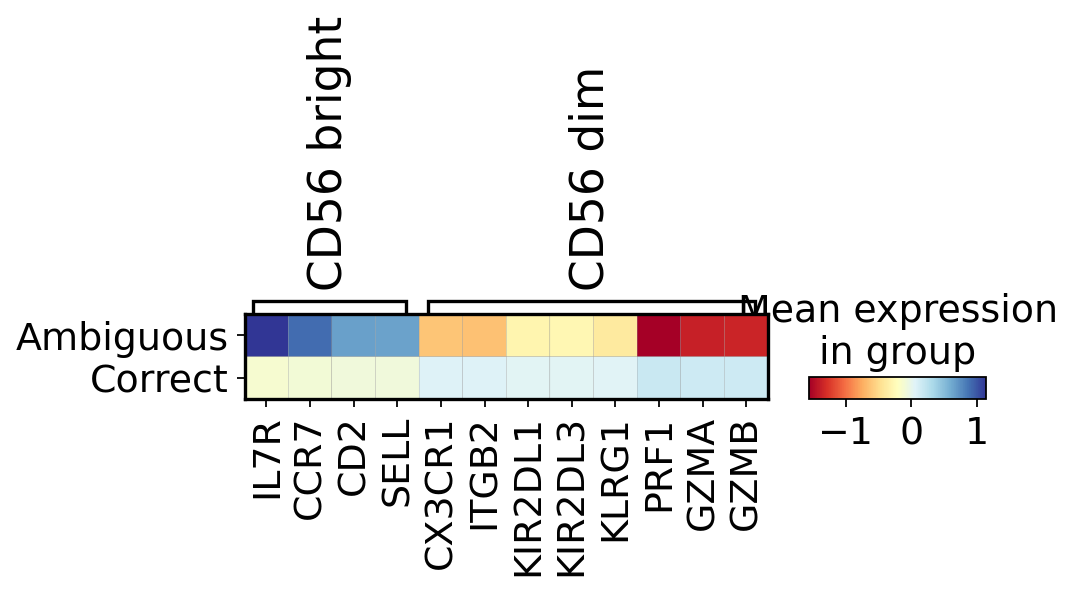

In [32]:
ax = sc.pl.matrixplot(adata_nk_sacled, cd56_genes_dict, groupby='amb_annotation',cmap='RdYlBu', gene_symbols='alt_names')


In [33]:
adata_nk.obs['conf_non_ambiguous'].value_counts()

True     410
False     47
Name: conf_non_ambiguous, dtype: int64

In [34]:
bdata= adata[adata.obs['conf_binaries'].isin([True])]
adata_nk= bdata[bdata.obs['str_labels'].isin(['NK cells'])]
adata_cd4= bdata[bdata.obs['str_labels'].isin(['CD4 T cells'])]
adata_cd8= bdata[bdata.obs['str_labels'].isin(['CD8 T cells'])]
adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.95) | (adata_nk.obs['var'] < 0.15))
adata_nk_cells_non_ambiguous= adata_nk[adata_nk.obs['conf_non_ambiguous'].isin([True])]
adata_nk_cells_ambiguou= adata_nk[adata_nk.obs['conf_non_ambiguous'].isin([False])]


/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  """


In [35]:
mean_non_ambiguous = np.mean(adata_nk_cells_non_ambiguous.X , axis=0)
mean_ambiguous = np.mean(adata_nk_cells_ambiguou.X , axis=0)
mean_cd8 = np.mean(adata_cd8.X , axis=0)
mean_cd4 = np.mean(adata_cd4.X , axis=0)

print(np.linalg.norm(mean_non_ambiguous-mean_ambiguous))
print(np.linalg.norm(mean_non_ambiguous-mean_cd8))
print(np.linalg.norm(mean_non_ambiguous-mean_cd4))
print(np.linalg.norm(mean_cd8-mean_ambiguous))
print(np.linalg.norm(mean_cd4-mean_ambiguous))


12.250724
13.778523
20.348095
10.118591
13.55198


In [36]:
A = np.zeros((4,4))
#mean_non_ambiguous -0
#mean_ambiguous -1
#mean_cd8 -2
#mean_cd4 -3

A[0,1]= np.linalg.norm(mean_non_ambiguous-mean_ambiguous)
A[0,2]= np.linalg.norm(mean_non_ambiguous-mean_cd8)
A[0,3]= np.linalg.norm(mean_non_ambiguous-mean_cd4)
A[1,0]= A[0,1]
A[1,2]= np.linalg.norm(mean_ambiguous-mean_cd8)
A[1,3]= np.linalg.norm(mean_ambiguous-mean_cd4)
A[2,0]= A[0,2]
A[2,1]= A[1,2]
A[2,3]= np.linalg.norm(mean_cd8-mean_cd4)
A[3,0]= A[0,3]
A[3,1]= A[1,3]
A[3,2]= A[2,3]


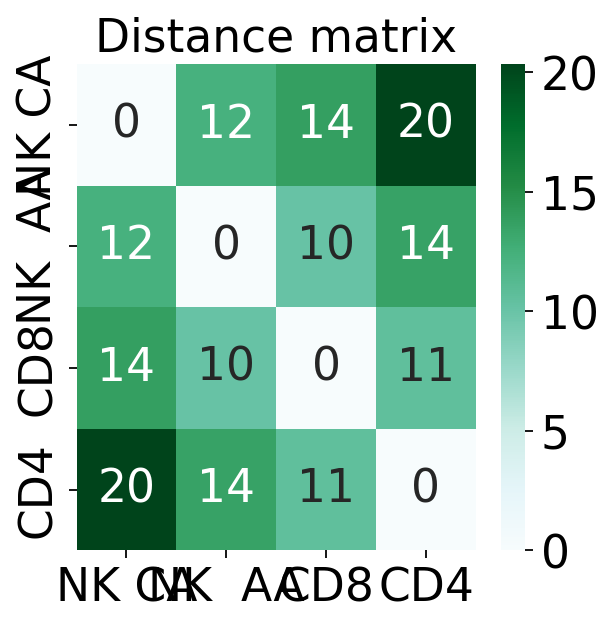

In [37]:
import seaborn as sns
g = sns.heatmap(A, annot=True,cmap='BuGn')
g.set_xticklabels(['NK CA','NK  AA','CD8','CD4'])
g.set_yticklabels(['NK CA','NK  AA','CD8','CD4'])
g.set_title('Distance matrix')
plt.show()

In [38]:
celltype_list= ["CD14+ Monocytes", "FCGR3A+ Monocytes"]#,'Dendritic Cells']
adata_monocytes= adata[adata.obs['conf_binaries'].isin([True])]
adata_monocytes= adata_monocytes[adata_monocytes.obs['str_labels'].isin(celltype_list)]
adata_monocytes.obs['non_conf_ambiguous'] = pd.Categorical((adata_monocytes.obs['conf'] > 0.95) &
                                                     (adata_monocytes.obs['var'] < 0.15))

adata_monocytes_scaled= adata_scaled[adata.obs['conf_binaries'].isin([True])]
adata_monocytes_scaled= adata_monocytes_scaled[adata_monocytes_scaled.obs['str_labels'].isin(celltype_list)]
adata_monocytes_scaled.obs['conf_ambiguous'] = pd.Categorical((adata_monocytes_scaled.obs['conf'] > 0.95) &
                                                     (adata_monocytes_scaled.obs['var'] < 0.15))


/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  """
/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  # Remove the CWD from sys.path while we load stuff.


In [39]:

adata_scaled.obs['conf']=adata.obs['conf']
adata_scaled.obs['var']=adata.obs['var']

adata_cd14_scaled= adata_scaled[adata.obs['conf_binaries'].isin([True])]
adata_cd14_scaled= adata_cd14_scaled[adata_cd14_scaled.obs['str_labels'].isin(["CD14+ Monocytes"])]
adata_cd14_scaled.obs['conf_ambiguous'] = pd.Categorical((adata_cd14_scaled.obs['conf'] > 0.95) &
                                                     (adata_cd14_scaled.obs['var'] < 0.15))

adata_fc_scaled= adata_scaled[adata.obs['conf_binaries'].isin([True])]
adata_fc_scaled= adata_fc_scaled[adata_fc_scaled.obs['str_labels'].isin(["FCGR3A+ Monocytes"])]
adata_fc_scaled.obs['conf_ambiguous'] = pd.Categorical((adata_fc_scaled.obs['conf'] > 0.95) &
                                                     (adata_fc_scaled.obs['var'] < 0.15))


/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  import sys
/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  if sys.path[0] == "":


In [40]:
adata_cd14_scaled.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14_scaled.obs['conf'] > 0.95) | (adata_cd14_scaled.obs['var'] < 0.15))
adata_fc_scaled.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc_scaled.obs['conf'] > 0.95) | (adata_fc_scaled.obs['var'] < 0.15))
adata_cd14= adata[adata.obs['str_labels'].isin(["CD14+ Monocytes"])]
adata_fc= adata[adata.obs['str_labels'].isin(["FCGR3A+ Monocytes"])]

annotation_list_cd14=[]
for i in range( adata_cd14.n_obs):
    if adata_cd14.obs['conf_non_ambiguous'][i]==True:
        annotation_list_cd14.append('Correct(annotated as CD14+)')
    else:
        annotation_list_cd14.append('Ambiguous(annotated as CD14+)')
annotation_list_fc=[]
for i in range( adata_fc.n_obs):
    if adata_fc.obs['conf_non_ambiguous'][i]==True:
        annotation_list_fc.append('Correct(annotated as FCGR3A+)')
    else:
        annotation_list_fc.append('Ambiguous(annotated as FCGR3A+)')
adata_cd14.obs['cell_state']=annotation_list_cd14
adata_fc.obs['cell_state']=annotation_list_fc
adata_fc_cd14= adata_cd14.concatenate(adata_fc)

sc.pp.scale(adata_fc_cd14)


/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


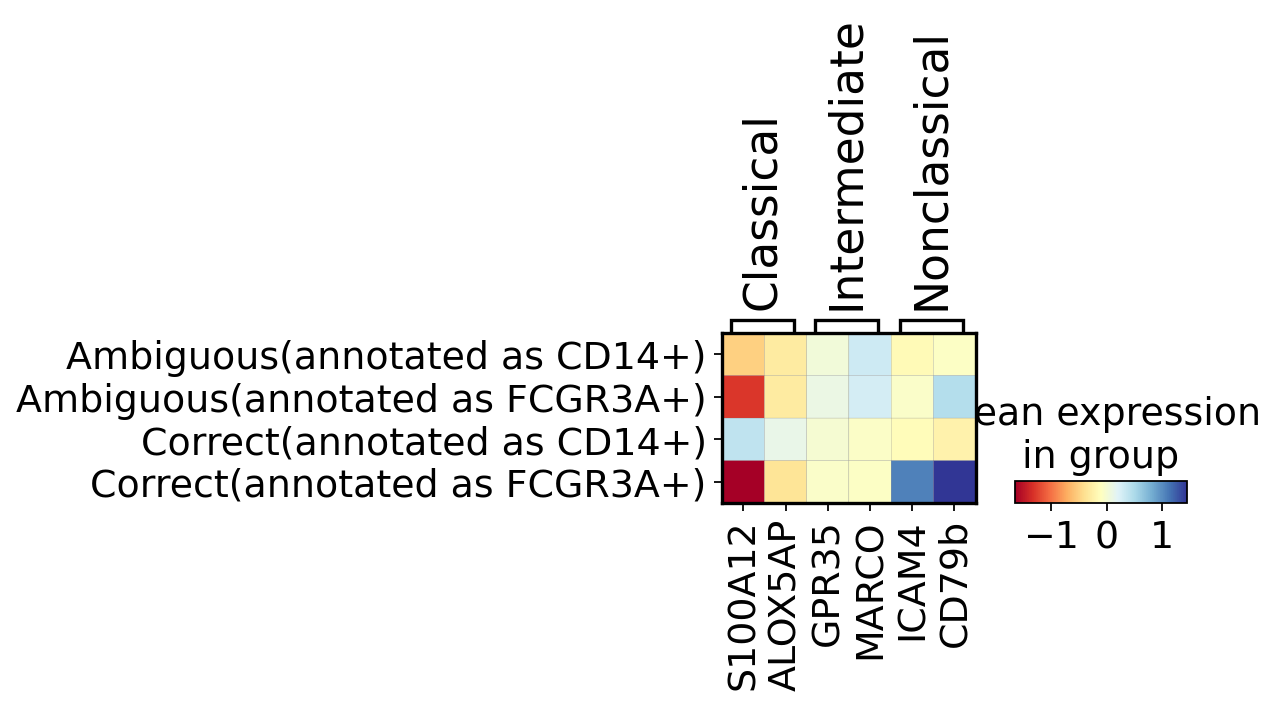

In [41]:

mono_genes_dict= {
    'Classical':['S100A12','ALOX5AP'], 
    'Intermediate':['GPR35','MARCO'], 
    'Nonclassical':['ICAM4','CD79b'], 
                   }

sc.pl.matrixplot(adata_fc_cd14, mono_genes_dict, groupby='cell_state' ,cmap='RdYlBu', gene_symbols='alt_names')


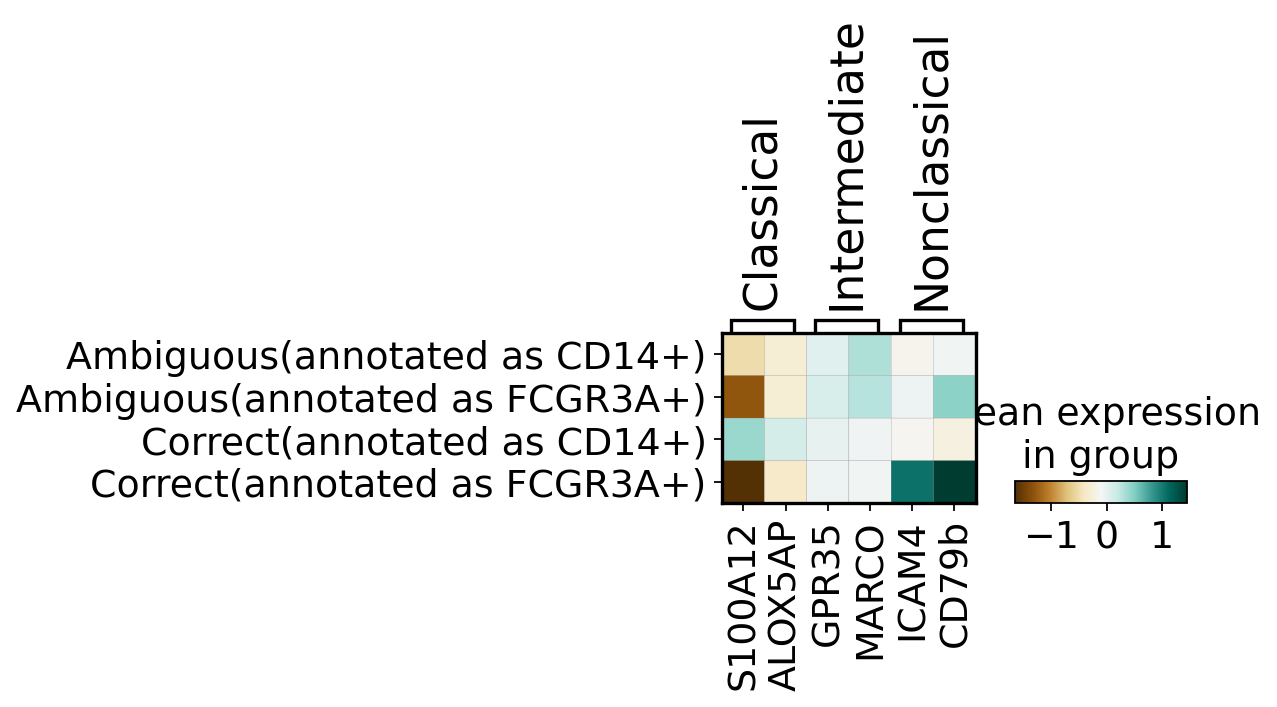

In [42]:
ax = sc.pl.matrixplot(adata_fc_cd14, mono_genes_dict, groupby='cell_state',cmap='BrBG', gene_symbols='alt_names')



In [43]:
adata_monocytes.obs['conf_non_ambiguos'] = pd.Categorical((adata_monocytes.obs['conf'] > 0.95) &
                                                     (adata_monocytes.obs['var'] < 0.15))
cd14_= adata_monocytes[adata_monocytes.obs['str_labels'].isin(['CD14+ Monocytes'])]
sc.tl.rank_genes_groups(cd14_,'conf_non_ambiguos','wilcoxon')

fc_= adata_monocytes[adata_monocytes.obs['str_labels'].isin(['FCGR3A+ Monocytes'])]
sc.tl.rank_genes_groups(fc_,'conf_non_ambiguos', 'wilcoxon')



In [44]:
#adata.var['alt_names'].loc['ENSG00000163221'] = 'S100A12'
#adata.var['alt_names'].loc['ENSG00000132965']='ALOX5AP'
#adata.var['alt_names'].loc['ENSG00000178623']='GPR35'
#adata.var['alt_names'].loc['ENSG00000019169']='MARCO'
#adata.var['alt_names'].loc['ENSG00000105371']='ICAM4'
#adata.var['alt_names'].loc['ENSG00000007312']='CD79b'

def get_gene_pvalue(adata, gene):
    for i, j in enumerate(adata.uns['rank_genes_groups']['names']):
        if j[0]==gene:
            print(adata.uns['rank_genes_groups']['pvals'][i])
    adata_amb= adata[adata.obs['conf_non_ambiguos'].isin([False])]
    print(np.mean(adata_amb[:,gene].X.toarray()))
    adata_cor= adata[adata.obs['conf_non_ambiguos'].isin([True])]
    print(np.mean(adata_cor[:,gene].X.toarray()))


print(get_gene_pvalue(cd14_,'ENSG00000163221'))
print(get_gene_pvalue(cd14_,'ENSG00000132965'))
print(get_gene_pvalue(cd14_,'ENSG00000178623'))
print(get_gene_pvalue(cd14_,'ENSG00000019169'))

print("******* ")
print(get_gene_pvalue(fc_,'ENSG00000105371'))
print(get_gene_pvalue(fc_,'ENSG00000007312'))
print(get_gene_pvalue(fc_,'ENSG00000178623'))
print(get_gene_pvalue(fc_,'ENSG00000019169'))


(3.08795656e-83, 3.16369553e-144)
2.4637585
3.850988
None
(1.23151811e-20, 5.50146665e-28)
0.2980859
0.6859656
None
(0.06955168, 0.30172412)
0.14949831
0.105162576
None
(5.34700628e-08, 0.10110047)
0.41308114
0.20269352
None
******* 
(2.23351916e-11, 2.76727793e-14)
0.118131
0.6552501
None
(1.40249075e-06, 0.00047702)
0.9269023
1.6204582
None
(0.17368429, 0.00523244)
0.16863492
0.08382745
None
(0.00217547, 2.25944249e-06)
0.50240517
0.16739927
None


In [45]:
import metrics
adata_fc = metrics.rank_genes_conf(adata_fc)

adata_fc.var['conf_score_high'].sort_values(ascending=False).index[:5]

/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Index(['ENSG00000103187', 'ENSG00000158869', 'ENSG00000185201',
       'ENSG00000108518', 'ENSG00000076944'],
      dtype='object')

In [46]:
intermediate_state_mapping = {
    'B cells': 'B cells',
    'CD4 T cells': 'CD4 T cells',
    'CD8 T cells': 'NK cells',
    'FCGR3A+ Monocytes': 'CD14+ Monocytes',
    'CD14+ Monocytes': 'FCGR3A+ Monocytes',
    'Dendritic Cells': 'Dendritic Cells',
    'NK cells': 'CD8 T cells'
}

# Create an empty list to store the updated cell types
cell_type_list = []
for i in range(adata.n_obs):
    cluster_name = adata.obs['str_labels'][i]
    if cluster_name in intermediate_state_mapping:
        cell_type_list.append(intermediate_state_mapping[cluster_name])
    else:
        cell_type_list.append(cluster_name)

# Update the cell type column in the AnnData object
adata.obs['str_labels_2'] = np.array(cell_type_list)
epoch_num=100
prob_list_1, prob_list_2 = models.follow_train_dyn_two_lables(adata, label_one='str_labels', label_two= 'str_labels_2', iterNum=epoch_num, device=device)

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.391
[1,    12] loss: 1.930
[1,    22] loss: 1.863
[1,    32] loss: 1.788
[1,    42] loss: 1.697
[2,     2] loss: 0.318
[2,    12] loss: 1.516
[2,    22] loss: 1.390
[2,    32] loss: 1.227
[2,    42] loss: 1.073
[3,     2] loss: 0.191
[3,    12] loss: 0.872
[3,    22] loss: 0.756
[3,    32] loss: 0.647
[3,    42] loss: 0.588
[4,     2] loss: 0.109
[4,    12] loss: 0.502
[4,    22] loss: 0.432
[4,    32] loss: 0.397
[4,    42] loss: 0.346
[5,     2] loss: 0.061
[5,    12] loss: 0.307
[5,    22] loss: 0.292
[5,    32] loss: 0.270
[5,    42] loss: 0.243
[6,     2] loss: 0.046
[6,    12] loss: 0.230
[6,    22] loss: 0.213
[6,    32] loss: 0.185
[6,    42] loss: 0.194
[7,     2] loss: 0.038
[7,    12] loss: 0.180
[7,    22] loss: 0.184
[7,    32] loss: 0.159
[7,    42] loss: 0.145
[8,     2] loss: 0.035
[8,    12] loss: 0.155
[8,    22] loss: 0.150
[8,    32] loss: 0.150
[8,    42] loss: 0.146
[9,     2] loss: 0.031
[9,    12] loss: 0.147
[9,    22] loss: 0.137
[9,    32] 

[71,    22] loss: 0.022
[71,    32] loss: 0.013
[71,    42] loss: 0.017
[72,     2] loss: 0.005
[72,    12] loss: 0.015
[72,    22] loss: 0.015
[72,    32] loss: 0.019
[72,    42] loss: 0.011
[73,     2] loss: 0.003
[73,    12] loss: 0.021
[73,    22] loss: 0.013
[73,    32] loss: 0.011
[73,    42] loss: 0.016
[74,     2] loss: 0.002
[74,    12] loss: 0.016
[74,    22] loss: 0.012
[74,    32] loss: 0.015
[74,    42] loss: 0.013
[75,     2] loss: 0.002
[75,    12] loss: 0.014
[75,    22] loss: 0.013
[75,    32] loss: 0.020
[75,    42] loss: 0.010
[76,     2] loss: 0.004
[76,    12] loss: 0.013
[76,    22] loss: 0.019
[76,    32] loss: 0.010
[76,    42] loss: 0.016
[77,     2] loss: 0.002
[77,    12] loss: 0.016
[77,    22] loss: 0.015
[77,    32] loss: 0.016
[77,    42] loss: 0.018
[78,     2] loss: 0.003
[78,    12] loss: 0.015
[78,    22] loss: 0.017
[78,    32] loss: 0.012
[78,    42] loss: 0.012
[79,     2] loss: 0.005
[79,    12] loss: 0.018
[79,    22] loss: 0.017
[79,    32] loss

In [47]:
for i in range(100):
    adata.obs['prob1_' +str(i)] = prob_list_1[i]
    adata.obs['prob2_' +str(i)] = prob_list_2[i]


/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until
/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [48]:
adata_cd14= adata[adata.obs['conf_binaries'].isin([True])]
adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.95) | (adata_cd14.obs['var'] < 0.15))

adata_cd14= adata_cd14[adata_cd14.obs['str_labels'].isin(['CD14+ Monocytes'])]
adata_cd14_miss= adata[adata.obs['conf_binaries'].isin([False])]
adata_cd14_miss= adata_cd14_miss[adata_cd14_miss.obs['str_labels'].isin(['CD14+ Monocytes'])]
adata_cd14_inter= adata_cd14[adata_cd14.obs['conf_non_ambiguous'].isin([False])]
adata_cd14_cd14= adata_cd14[adata_cd14.obs['conf_non_ambiguous'].isin([True])]


/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  


In [49]:

prob_cd14_cd14 = []
std_cd14_cd14 = []
prob_cd14_miss = []
std_cd14_miss = []
prob_inter_cd14 = []
std_inter_cd14 = []
prob_inter_fc = []
std_inter_fc = []

for i in range(100):
    prob_cd14_cd14.append(np.mean(adata_cd14_cd14.obs['prob1_' +str(i)]))
    prob_cd14_miss.append(np.mean(adata_cd14_miss.obs['prob1_' +str(i)]))
    prob_inter_cd14.append(np.mean(adata_cd14_inter.obs['prob1_' +str(i)]))
    prob_inter_fc.append(np.mean(adata_cd14_inter.obs['prob2_' +str(i)]))
    std_cd14_cd14.append(np.std(adata_cd14_cd14.obs['prob1_' +str(i)]))
    std_cd14_miss.append(np.std(adata_cd14_miss.obs['prob1_' +str(i)]))
    std_inter_cd14.append(np.std(adata_cd14_inter.obs['prob1_' +str(i)]))
    std_inter_fc.append(np.std(adata_cd14_inter.obs['prob2_' +str(i)]))



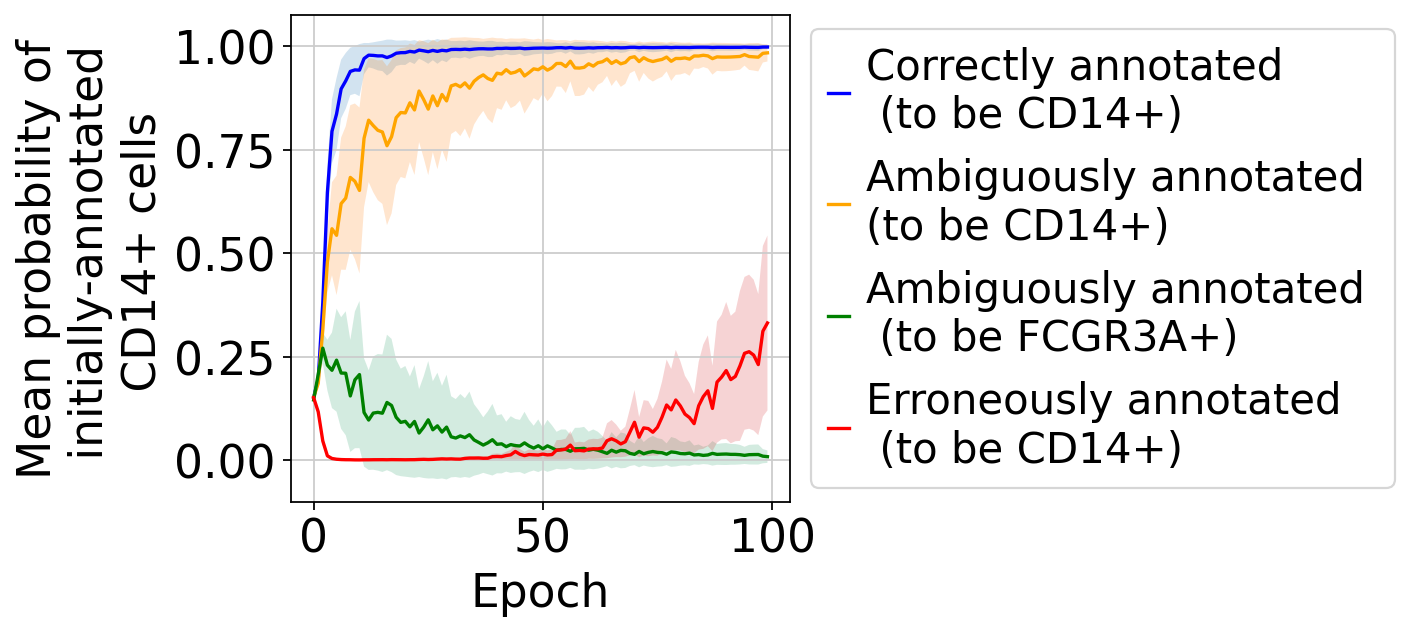

In [52]:
std_cd14_cd14 = np.array(std_cd14_cd14)
prob_cd14_cd14  = np.array(prob_cd14_cd14)
prob_inter_cd14 = np.array(prob_inter_cd14)
std_inter_cd14 = np.array(std_inter_cd14)
prob_inter_fc = np.array(prob_inter_fc)
std_inter_fc = np.array(std_inter_fc)
prob_cd14_miss = np.array(prob_cd14_miss)
std_cd14_miss = np.array(std_cd14_miss)

plt.plot(range(100),prob_cd14_cd14[:100],label='Correctly annotated\n (to be CD14+)', color='b')
plt.fill_between(range(100), prob_cd14_cd14-std_cd14_cd14, prob_cd14_cd14+std_cd14_cd14, interpolate=True, alpha=0.2)
plt.plot(range(100),prob_inter_cd14[:100], label='Ambiguously annotated \n(to be CD14+)', color='orange')
plt.fill_between(range(100), prob_inter_cd14-std_inter_cd14, prob_inter_cd14+std_inter_cd14, interpolate=True,  alpha=0.2)
plt.plot(range(100),prob_inter_fc[:100], label='Ambiguously annotated\n (to be FCGR3A+)', color='g')
plt.fill_between(range(100), prob_inter_fc-std_inter_fc, prob_inter_fc+std_inter_fc, interpolate=True,  alpha=0.2)
plt.plot(range(100),prob_cd14_miss[:100], label='Erroneously annotated\n (to be CD14+)', color='r')
plt.fill_between(range(100), prob_cd14_miss-std_cd14_miss, prob_cd14_miss+std_cd14_miss, interpolate=True,  alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Mean probability of\n initially-annotated\n CD14+ cells')
#plt.ylabel('Spacing of\nZeroes of\n$J_{\\nu}(x)$', rotation=0, ha="right")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



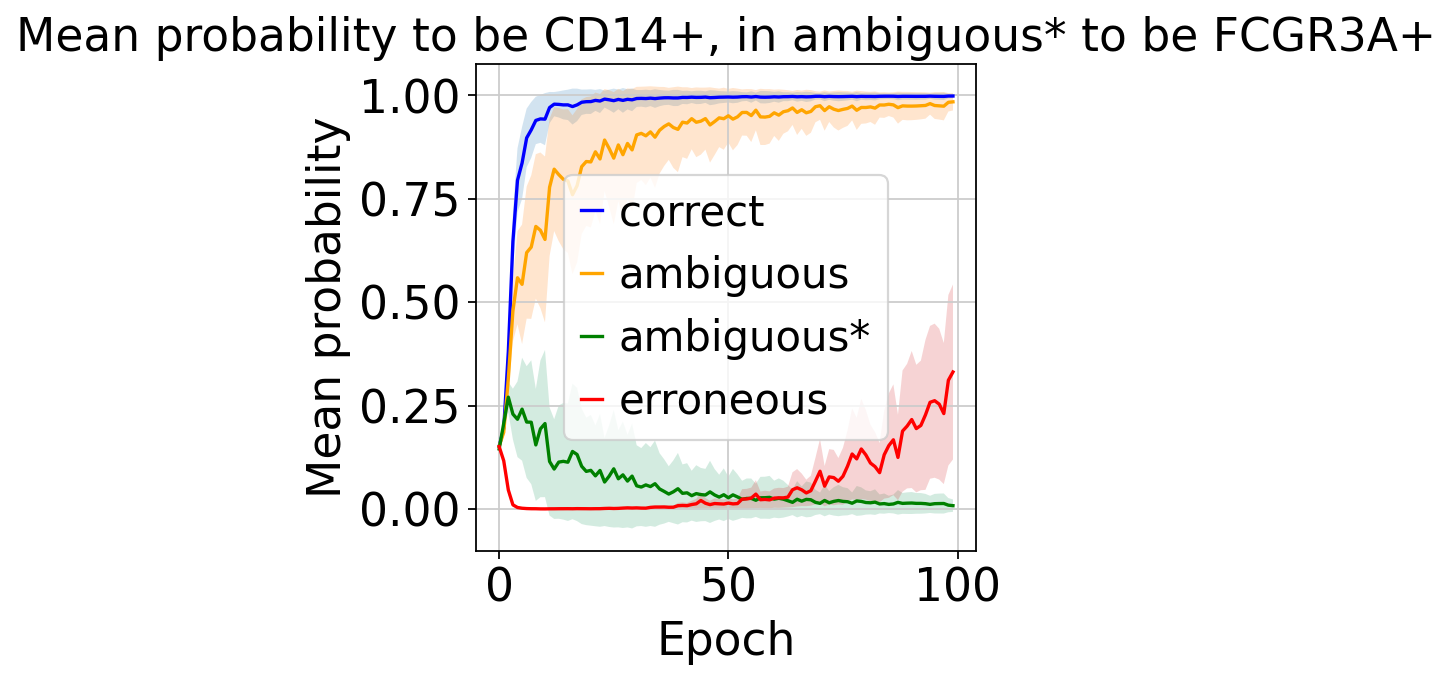

In [51]:
plt.plot(range(100),prob_cd14_cd14[:100],label='correct', color='b')
plt.fill_between(range(100), prob_cd14_cd14-std_cd14_cd14, prob_cd14_cd14+std_cd14_cd14, interpolate=True, alpha=0.2)
plt.plot(range(100),prob_inter_cd14[:100], label='ambiguous', color='orange')
plt.fill_between(range(100), prob_inter_cd14-std_inter_cd14, prob_inter_cd14+std_inter_cd14, interpolate=True,  alpha=0.2)
plt.plot(range(100),prob_inter_fc[:100], label='ambiguous*', color='g')
plt.fill_between(range(100), prob_inter_fc-std_inter_fc, prob_inter_fc+std_inter_fc, interpolate=True,  alpha=0.2)
plt.plot(range(100),prob_cd14_miss[:100], label='erroneous', color='r')
plt.fill_between(range(100), prob_cd14_miss-std_cd14_miss, prob_cd14_miss+std_cd14_miss, interpolate=True,  alpha=0.2)
plt.xlabel('Epoch')
plt.title('Mean probability to be CD14+, in ambiguous* to be FCGR3A+')
plt.ylabel('Mean probability')
#plt.ylabel(' mean probability to be classical (CD14+), except in ambiguous*, it is the probability to be non-classical (FCGR3A+)')
plt.legend()
plt.show()

